## k-最近邻（kNN）练习
填写并提交此已完成的工作表（包括其输出和工作表外的任何支持代码）以及您的作业提交。有关更多详细信息，请参阅课程网站上的作业页面。
kNN分类器由两个阶段组成：

<p>
   在训练过程中，分类器获取训练数据并简单地记住它<br>
   在测试过程中，kNN通过比较所有训练图像并转移k个最相似训练示例的标签来对每个测试图像进行分类<br>
   k的值经过交叉验证<br>
</p>

在本练习中，您将实现这些步骤，了解基本的图像分类管道、交叉验证，并熟练编写高效的矢量化代码。

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


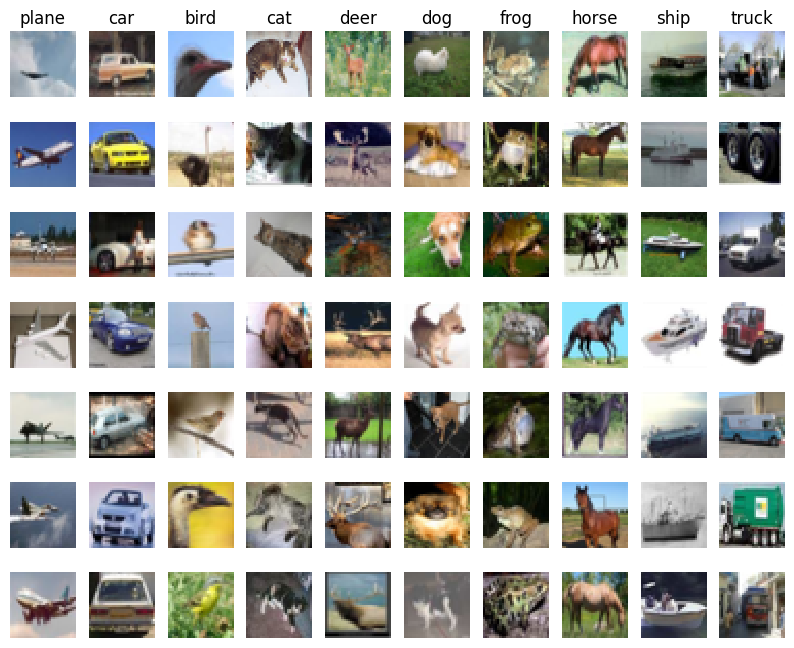

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [5]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

我们现在想用kNN分类器对测试数据进行分类。回想一下，我们可以将这个过程分为两个步骤：

1.首先，我们必须计算所有测试示例和所有训练示例之间的距离。
2.给定这些距离，对于每个测试示例，我们找到k个最近的示例，并让它们投票给标签

让我们从计算所有训练和测试示例之间的距离矩阵开始。例如，如果有**Ntr**训练示例和**Nte**测试示例，则此阶段应产生**Nte x Ntr**矩阵，其中每个元素（i，j）是第i个测试和第j个训练示例之间的距离。

**注意：对于我们要求您在本笔记本中实现的三个距离计算，您可能无法使用numpy提供的np.linalg.norm（）函数**

首先，打开`cs231n/分类器/k_nearest_neighbor.py `，并实现函数`compute_distances_two_loops`，该函数在所有（测试、训练）示例对上使用（非常低效）双环，并一次计算一个元素的距离矩阵。

In [6]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)
print(dists[0:10,0:10])

500
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
(500, 5000)
[[3803.92350081 4210.59603857 5504.0544147  3473.88960677 4371.58632535
  4447.85127899 3886.35060179 4058.59187404 5175.54760388 4678.74855063]
 [6336.83367306 5270.28006846 4040.63608854 6430.498892   5350.64407338
  6094.37987001 5271.94688896 6546.65173963 5710.24097565 6404.07628   ]
 [5224.83913628 4250.64289255 3773.94581307 5213.55799814 3761.53572361
  5260.55082667 4366.72863824 5405.09962905 4601.2692814  5246.72850451]
 [5265.83754022 4274.49459001 4593.32254474 5692.80598651 4982.8210885
  5412.18920586 4307.1045959  5189.83997827 4967.28356348 6262.7882768 ]
 [3163.80277514 4231.52395716 6134.35889071 2953.75032797 4255.45825969
  4356.26824243 3837.93551275 3835.97028143 4923.86403143 5053.92876879]
 [3072.51281527 4256.22179873 5351.42317519 2671.23492041 4312.94980263

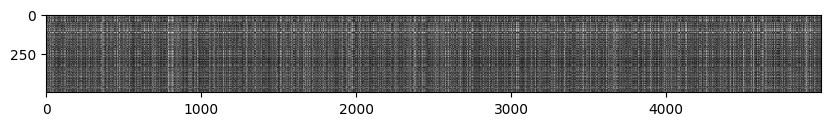

In [7]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**内联问题1**

请注意距离矩阵中的结构化图案，其中一些行或列明显更亮。（请注意，在默认配色方案中，黑色表示低距离，白色表示高距离。）

-数据中明显明亮的行背后的原因是什么？
-是什么导致了这些列？

您的答案：    1.行高亮：对于测试集中的当前行所处的图片，在训练集中所有的图片都与其不太相似，距离较远</br>
    2.列高亮：对于训练集中的当前行所处的图片，在测试集中所有的图片都与其不太相似，距离较远

In [8]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [9]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 144 / 500 correct => accuracy: 0.288000


**内联问题2**

我们还可以使用其他距离度量，如L1距离。
对于某个图像$i_k$的位置$（i，j）$处的像素值$p_{ij}^{（k）}$，

所有图像上所有像素的平均$\mu$为$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{1}^{h}\sum_{j=1}^{w}p_{ij}^{（k）}$$
所有图像的像素平均值$\mu_{ij}$为
$$\mu{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{（k）}$$
一般标准偏差$\sigma$和逐像素标准偏差$\sigma_{ij}$的定义类似。

以下哪个预处理步骤不会改变使用L1距离的最近邻分类器的性能？选择所有适用项。为了澄清，训练和测试示例都以相同的方式进行预处理。

1.减去平均值$\mu$（$\tilde{p}_{ij}^{（k）}=p_{ij}^{（k）}-\mu$。）
2.减去每个像素的平均值$\mu_{ij}$（$\tilde{p}_{ij}^{（k）}=p_{ij}^{（k）}-\mu_{ij}$。）
3.减去平均值$\mu$，除以标准偏差$\sigma$。
4.减去像素平均值$\mu_{ij}$，除以像素标准偏差$\sigma_{ij}$。
5.旋转数据的坐标轴，这意味着将所有图像旋转相同的角度。图像中由旋转引起的空白区域用相同的像素值填充，不进行插值。

$\color{blue}{\textit您的答案：1,3,}$


$\color{blue}{\textit您的解释：}$

In [10]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
#现在，让我们通过使用部分矢量化来加速距离矩阵计算
#一个循环。实现函数compute_distances_one_loop并运行
#为了确保我们的矢量化实现是正确的，我们确保它
#同意天真的实施。有很多方法可以决定是否
#两个矩阵是相似的；其中最简单的一个是Frobenius范数。万一
#你以前没见过，两个矩阵的Frobenius范数是平方
#所有元素差的平方和的根；换句话说，重塑
#将矩阵转换为向量，并计算它们之间的欧几里德距离。
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
One loop difference was: 0.000000
Good! The distance matrices are the same


In [11]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

500
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
Two loop version took 20.928515 seconds
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
One loop version took 35.572398 seconds
No loop version took 0.128579 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [23]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
print(X_train.shape)
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds =np.array_split(X_train,num_folds,0)
y_train_folds =np.array_split(y_train,num_folds,0)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:
    print(k)
    templist=[]
    for j in range(num_folds):
        temp_X_train=np.array(X_train_folds[0:j]+X_train_folds[j+1:num_folds]).reshape(4000,3072)
        temp_X_validation=np.array(X_train_folds[j])
        temp_y_train=np.array(y_train_folds[0:j]+y_train_folds[j+1:num_folds]).reshape(4000,1)
        temp_y_validation=np.array(y_train_folds[j]).reshape(1000,1)
        #print(temp_X_train.shape,temp_X_validation.shape,temp_y_train.shape,temp_y_validation.shape)
        validation_ClassFier=KNearestNeighbor()
        validation_ClassFier.train(temp_X_train,temp_y_train)
        temp_y_pre=validation_ClassFier.predict(temp_X_validation,k,0).reshape(1000,1)
        print(temp_y_pre.shape,temp_y_validation.shape)
        num_correct=np.sum(temp_y_pre==temp_y_validation)
        templist.append(num_correct/len(temp_y_pre))
    k_to_accuracies[k]=templist
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

(5000, 3072)
1
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
3
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
5
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
8
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
10
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
12
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
15
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
20
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
50
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
100
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)
(1000, 1) (1000, 1)


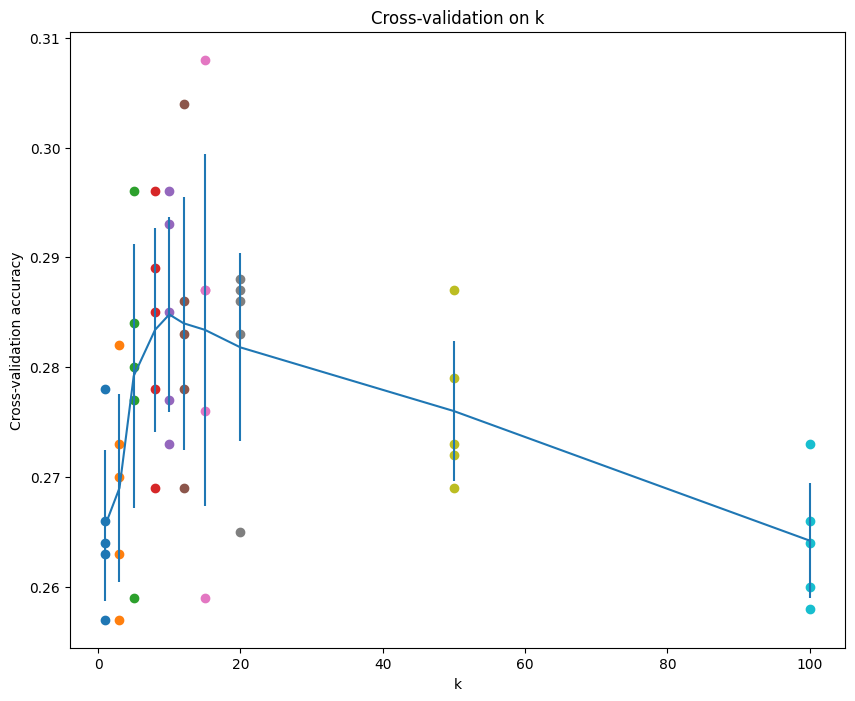

In [24]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [30]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 144 / 500 correct => accuracy: 0.288000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$4


$\color{blue}{\textit Your Explanation:}$


